In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)

In [3]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [5]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*",'wgt'], entrystop=3e6,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*",'wgt'], entrystop=3e6,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    print('Dataframe has a total of ', df.shape[0], ' entries')
    print('####################################################################')

    return df


In [19]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [23]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_pz = jet_pt*sinh(jet_eta)', inplace=True)

    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    temp.eval('jet_dphi = 3.14159265359 -abs(e_phi-jet_phi)',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('Q = sqrt(Q2)', inplace=True)
    temp = applyCut(temp, 'pass_reco==0 | 0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'pass_reco==0 | Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta>-1.0', 'jet eta > -1.0')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta<2.5', 'jet eta < 2.5')

    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gen_Q    = sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_pz = genjet_pt*sinh(genjet_eta)', inplace=True)

        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = 3.14159265359- abs(gene_phi-genjet_phi)',inplace=True)
        
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [7]:
#mc_name = 'Django'
#altmc_name = 'Rapgap'

mc_name = 'Django'
altmc_name = 'Rapgap'

In [8]:
mc_tag = 'nominal' ##could be "sys_0 or sys_1, etc"
data_tag  = 'nominal'
period = 'ep0607'

In [9]:
#path= '/data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/'
#path = '/data0/users/marratia/HERAdata/out_ep0607/'

path = '/home/miguel/21-01-28-06-37-test34/out_ep0607/'
data = get_Dataframe(path, name='Data', tag=data_tag)

filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Data_Eplus0607_0.nominal.root
[b'Data;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Data_Eplus0607_2.nominal.root
[b'Data;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Data_Eplus0607_3.nominal.root
[b'Data;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Data_Eplus0607_1.nominal.root
[b'Data;1']
####################################################################
Dataframe has a total of  371425  entries
####################################################################


In [11]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_134.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_13.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_121.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_151.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_7.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Django_Eplus0607_3.nominal.root
[b'Django;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep

In [12]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)


filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_131.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_103.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_117.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_4.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out_ep0607/Rapgap_Eplus0607_136.nominal.root
[b'Rapgap;1']
filename is /home/miguel/21-01-28-06-37-test34/out

## Define the pass_reco and pass_tuth flags. i.e. whether row in the dataframe jet has a reco-level jet, and whether it has a valid truth-level jet. 

In [13]:
%%time 
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['genjet_pt']*mc['Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['genjet_pt']*altmc['gen_Q2']>0, 1, 0)

data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

CPU times: user 1.17 s, sys: 564 ms, total: 1.74 s
Wall time: 1.33 s


In [14]:
mc.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz', 'wgt', 'pass_reco', 'pass_truth'],
      dtype='object')

In [24]:
%%time 

print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)

Selecting data events

0.08 < y < 0.7 250736  fraction kept: 100.0
Q2>150 250736  fraction kept: 100.0
jet pT > 5 GeV 250736  fraction kept: 100.0
jet eta > -1.0 250736  fraction kept: 100.0
jet eta < 2.5 250736  fraction kept: 100.0
Selecting MC events

0.08 < y < 0.7 23694493  fraction kept: 100.0
Q2>150 23694493  fraction kept: 100.0
jet pT > 5 GeV 23694493  fraction kept: 100.0
jet eta > -1.0 23694493  fraction kept: 100.0
jet eta < 2.5 23694493  fraction kept: 100.0
 pass_truth>0 23694493  fraction kept: 100.0
Selecting MC events

0.08 < y < 0.7 76958722  fraction kept: 100.0
Q2>150 76958722  fraction kept: 100.0
jet pT > 5 GeV 76958722  fraction kept: 100.0
jet eta > -1.0 76958722  fraction kept: 100.0
jet eta < 2.5 76958722  fraction kept: 100.0
 pass_truth>0 76958722  fraction kept: 100.0
CPU times: user 54.1 s, sys: 21.8 s, total: 1min 15s
Wall time: 59.3 s


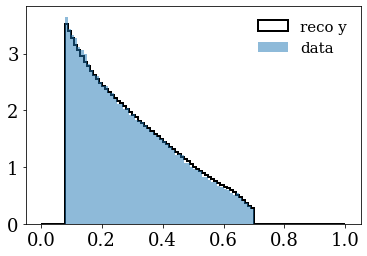

In [21]:
plt.hist(mc.query('pass_reco==1')['y'],weights = mc.query('pass_reco==1')['wgt'], range=(0,1),bins=100,**plot_style_1,label='reco y')
plt.hist(data['y'],range=(0,1),bins=100, **plot_style_2, label='data')
plt.legend()
plt.show()

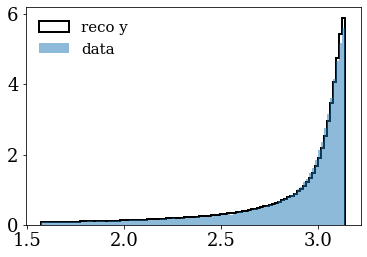

In [25]:
plt.hist(mc.query('pass_reco==1')['jet_dphi'],weights = mc.query('pass_reco==1')['wgt'], range=(np.pi/2.0,np.pi),bins=100,**plot_style_1,label='reco y')
plt.hist(data['jet_dphi'],range=(np.pi/2.0,np.pi),bins=100, **plot_style_2, label='data')
plt.legend()
plt.show()

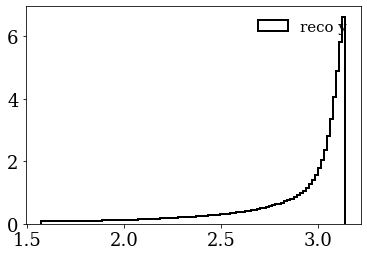

In [26]:
plt.hist(mc.query('pass_reco==1')['genjet_dphi'],weights = mc.query('pass_reco==1')['wgt'], range=(np.pi/2.0,np.pi),bins=100,**plot_style_1,label='reco y')
plt.legend()
plt.show()

## Event selection

In [27]:
label_DISselection = r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$'

In [28]:
data.head()

jet_pt   jet_phi   jet_eta  jet_dphi          Q2         y  \
entry subentry                                                                  
1     0         13.375306  0.694599 -0.200293  3.085314  186.193192  0.413862   
      1          5.949738 -1.204232  2.355365  1.186483  186.193192  0.413862   
4     0         12.692886 -0.213480  0.209102  3.010800  296.473389  0.235721   
7     0         17.961945 -1.262607  0.770954  3.092386  226.002777  0.140928   
11    0         10.802673  1.231192  0.284638  2.824875  211.652069  0.167709   

                     e_px       e_py       e_pz  wgt  pass_reco     jet_px  \
entry subentry                                                               
1     0          7.575202   7.069456 -14.227906  1.0          1  10.276389   
      1          7.575202   7.069456 -14.227906  1.0          1   2.132444   
4     0         14.719972  -1.219937 -17.624556  1.0          1  12.404751   
7     0          3.730844 -14.082226 -23.870697  1.0          1   5.448469   
11    0          8.110869  10.530479 -21.122046  1.0          1   3.598522   

                   jet_py     jet_pz     jet_qt  jet_qtnorm       e_pt  \
entry subentry                                                           
1     0          8.561229  -2.696923  23.727570    1.738887  10.361510   
      1         -5.554463  31.078804   9.825150    0.720041  10.361510   
4     0         -2.689147   2.673488  27.404953    1.591608  14.770437   
7     0        -17.115656  15.260970  32.520264    2.163203  14.568056   
11    0         10.185696   3.116540  23.796423    1.635688  13.291998   

                   e_phi     logQ2          Q  
entry subentry                                 
1     0         0.750877  2.269964  13.645263  
      1         0.750877  2.269964  13.645263  
4     0        -0.082687  2.471986  17.218403  
7     0        -1.311813  2.354114  15.033389  
11    0         0.914475  2.325623  14.548266

In [29]:
mc.head()

jet_pt   jet_phi      jet_eta  jet_dphi  genjet_pt  \
entry subentry                                                            
1     0           10.843917  0.645760    -0.079351  2.794532  10.887182   
      1        -9999.000000  0.689416 -9999.000000  2.750875   3.271572   
8     0           14.971306  0.406741     1.119547  3.088426  14.393229   
15    0           44.576412 -0.596459     0.445278  3.106366  46.312096   
18    0           14.344785 -1.005179     1.160051  2.394813  12.841123   

                genjet_phi  genjet_eta           Q2       gen_Q2         y  \
entry subentry                                                               
1     0           0.647824   -0.072111   175.455582   170.670380  0.244163   
      1          -0.306808    2.275355   175.455582   170.670380  0.244163   
8     0           0.414035    1.240932   357.716492   346.562927  0.151013   
15    0          -0.526331    0.444314  5858.060547  5962.764160  0.570241   
18    0          -1.030930    1.159103   442.950928   449.570923  0.198765   

                ...  gen_logQ2      gen_Q    gene_pt  genjet_px  genjet_py  \
entry subentry  ...                                                          
1     0         ...   2.232158  13.064088  11.390389   8.681427   6.569898   
      1         ...   2.232158  13.064088  11.390389   3.118797  -0.988072   
8     0         ...   2.539782  18.616201  17.261740  13.177074   5.790489   
15    0         ...   3.775448  77.218933  49.376808  40.044037 -23.265537   
18    0         ...   2.652798  21.203087  18.898848   6.600606 -11.014828   

                genjet_pz  genjet_qt  genjet_qtnorm  gene_phi  genjet_dphi  
entry subentry                                                              
1     0         -0.785763   3.913221       0.299540  0.297549     2.791318  
      1         15.750342   8.894757       0.680856  0.297549     2.537236  
8     0         22.811266   2.953231       0.158638  0.458594     3.097034  
15    0         21.260880  95.674110       1.238998 -0.561507     3.106417  
18    0         18.448231  29.486441       1.390667 -0.257800     2.368463  

[5 rows x 39 columns]

### Define UniFold Algorithm


In [30]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))





def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)
def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,weights_MC_sim,weights_MC_data=None,verbose=1):
    
    
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(theta_unknown_S))
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    
    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    earlystopping = EarlyStopping(patience=10,
                              verbose=verbose,
                              restore_best_weights=True)
    
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim
    
    #weights_pull = np.ones(len(theta0_S))
    #weights_push = np.ones(len(theta0_S))
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))
        print("STEP 1\n")
        
        weights_1 = np.concatenate((weights_push,weights_MC_data ))
        
        
      
        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
        
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
        batch_size=10000
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=verbose)
       
        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1
        weights[i, :1, :] = weights_pull
        
        print("\nSTEP 2\n")
        weights_2 = np.concatenate((weights_MC_sim, weights_pull))

        #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth
        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)
    
        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=1)
        #weights_push = reweight(theta0_G)
        weights_push = weights_MC_sim * reweight(theta0_G)

        weights[i, 1:2, :] = weights_push
   
    return weights, model

    




## Define features with data

In [31]:
mc_cut = mc[:2500000]
data_cut = data[:50000]

print(len(mc_cut))
print(len(data_cut))

2500000
50000


In [32]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
ratio = len(mc_cut.query('pass_reco==1'))/len(data_cut)
print(ratio)

50000
1948015
2500000
38.9603


In [33]:
mc_cut.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz', 'wgt', 'pass_reco', 'pass_truth',
       'jet_px', 'jet_py', 'jet_pz', 'jet_qt', 'jet_qtnorm', 'e_pt', 'e_phi',
       'logQ2', 'Q', 'gen_logQ2', 'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py',
       'genjet_pz', 'genjet_qt', 'genjet_qtnorm', 'gene_phi', 'genjet_dphi'],
      dtype='object')

In [34]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_S = data_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_S = data_cut['jet_qt']


weight_MC = mc_cut['wgt']
# Q_0_G           = mc_cut['gen_Q']
# Q_0_S           = mc_cut['Q']
# Q_unknown_S     = data_cut['Q']

In [35]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [36]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10



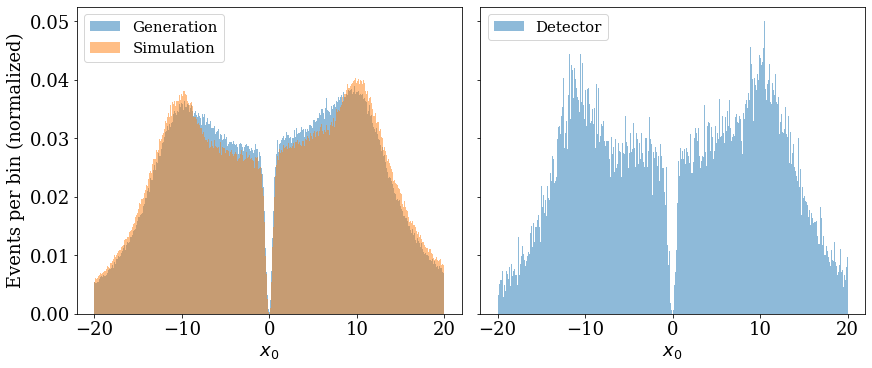

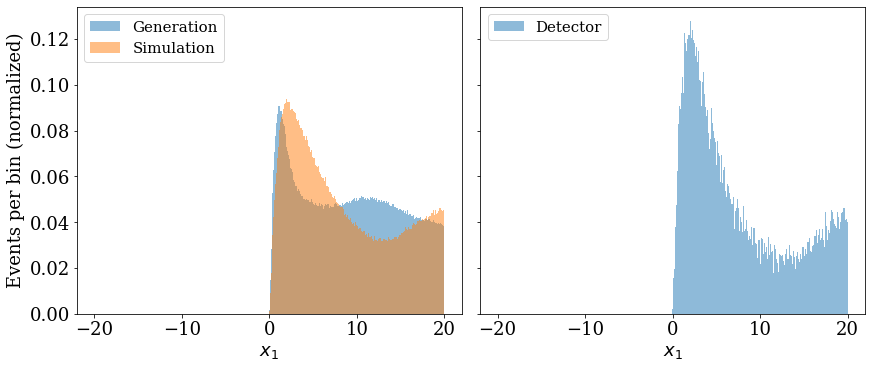

In [37]:
bins = np.linspace(-20,20,400)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

#bins = np.linspace(-180,180, 101)
#bins = np.linspace(0,2, 101)
bins = np.linspace(-20,20,400)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')
ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1],bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

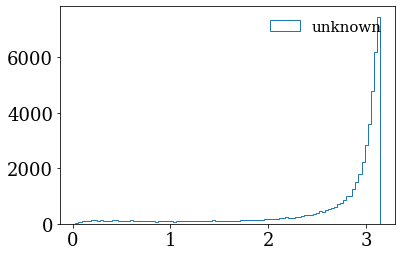

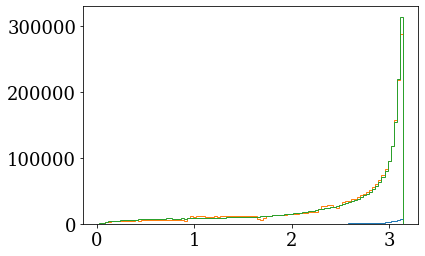

In [38]:
plt.hist(jetdphi_unknown_S,bins=100, histtype='step',label='unknown')
#plt.hist(jetdphi_0_S,bins=100, histtype='step',label='epx_S')
#plt.hist(jetdphi_0_G,bins=100, histtype='step',label='epx_G')
plt.legend()
plt.show()
plt.hist(jetdphi_unknown_S,bins=100, histtype='step')
plt.hist(jetdphi_0_S,bins=100, histtype='step')
plt.hist(jetdphi_0_G,bins=100, histtype='step')
plt.show()

## Run unfolding on data

In [39]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [40]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [41]:
%%time 
iterations =3# use ~4 iterations
num_observables= 8
K.clear_session()
weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,weights_MC_sim =weight_MC,verbose=1)


ITERATION: 1

STEP 1

Epoch 1/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0630 - accuracy: 0.0427 - val_loss: 0.0620 - val_accuracy: 0.0199
Epoch 2/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0204 - val_loss: 0.0620 - val_accuracy: 0.0202
Epoch 3/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0205 - val_loss: 0.0620 - val_accuracy: 0.0202
Epoch 4/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0622 - accuracy: 0.0205 - val_loss: 0.0619 - val_accuracy: 0.0200
Epoch 5/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.0205 - val_loss: 0.0619 - val_accuracy: 0.0199
Epoch 6/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0621 - accuracy: 0.0204 - val_loss: 0.0619 - val_accuracy: 0.0200
Epoch 7/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0520 - accuracy: 0.0456 - val_loss: 0.0183

375/375 [==============================] - 1s 2ms/step - loss: 0.0186 - accuracy: 0.3051 - val_loss: 0.0186 - val_accuracy: 0.3054
Epoch 19/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0186 - accuracy: 0.3051 - val_loss: 0.0186 - val_accuracy: 0.3054
Epoch 20/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0186 - accuracy: 0.3051 - val_loss: 0.0186 - val_accuracy: 0.3054
Epoch 21/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.3051 - val_loss: 0.0186 - val_accuracy: 0.3054
Epoch 22/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.3051 - val_loss: 0.0186 - val_accuracy: 0.3054
Epoch 23/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.3051 - val_loss: 0.0186 - val_accuracy: 0.3054
Epoch 24/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.3051 - val_loss: 0.0186 - val_accuracy: 0.3054
Epoch

Epoch 75/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.3051 - val_loss: 0.0185 - val_accuracy: 0.3054
Epoch 76/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0185 - accuracy: 0.3051 - val_loss: 0.0185 - val_accuracy: 0.3054
Epoch 00076: early stopping

ITERATION: 2

STEP 1

Epoch 1/200
192/192 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.4276 - val_loss: 0.0403 - val_accuracy: 0.4148
Epoch 2/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.4381 - val_loss: 0.0395 - val_accuracy: 0.4738
Epoch 3/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.4508 - val_loss: 0.0394 - val_accuracy: 0.4757
Epoch 4/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.4564 - val_loss: 0.0392 - val_accuracy: 0.4684
Epoch 5/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0391 - accur

375/375 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.3053 - val_loss: 0.0178 - val_accuracy: 0.3050
Epoch 21/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.3053 - val_loss: 0.0178 - val_accuracy: 0.3050
Epoch 22/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.3053 - val_loss: 0.0178 - val_accuracy: 0.3050
Epoch 23/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.3052 - val_loss: 0.0178 - val_accuracy: 0.3050
Epoch 24/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.3052 - val_loss: 0.0177 - val_accuracy: 0.3050
Epoch 25/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.3053 - val_loss: 0.0178 - val_accuracy: 0.3050
Epoch 26/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0177 - accuracy: 0.3053 - val_loss: 0.0178 - val_accuracy: 0.3050
Epoch

Epoch 24/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.3857 - val_loss: 0.0368 - val_accuracy: 0.4209
Epoch 25/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.3903 - val_loss: 0.0369 - val_accuracy: 0.3856
Epoch 26/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.3907 - val_loss: 0.0369 - val_accuracy: 0.3984
Epoch 27/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.3908 - val_loss: 0.0368 - val_accuracy: 0.3758
Epoch 28/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.3881 - val_loss: 0.0368 - val_accuracy: 0.3953
Epoch 29/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.3894 - val_loss: 0.0369 - val_accuracy: 0.4324
Epoch 30/200
192/192 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.3898 - val_loss: 0.0369 - val_accuracy:

Epoch 23/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.3051 - val_loss: 0.0178 - val_accuracy: 0.3055
Epoch 24/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.3051 - val_loss: 0.0178 - val_accuracy: 0.3055
Epoch 25/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.3051 - val_loss: 0.0178 - val_accuracy: 0.3055
Epoch 26/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.3051 - val_loss: 0.0177 - val_accuracy: 0.3055
Epoch 27/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.3051 - val_loss: 0.0177 - val_accuracy: 0.3056
Epoch 28/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.3051 - val_loss: 0.0178 - val_accuracy: 0.3055
Epoch 29/200
375/375 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.3051 - val_loss: 0.0177 - val_accuracy:

## Incorporate weights into the dataframe

In [42]:
mc_cut['weight_reco'] =  weights[-2, 0, :]
mc_cut['weight_truth'] = weights[-2, 1, :]

<ipython-input-42-afc8f285f76b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_reco'] =  weights[-2, 0, :]
<ipython-input-42-afc8f285f76b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_truth'] = weights[-2, 1, :]


In [43]:
mc_cut['weight_reco_next'] = weights[-1, 0, :]
mc_cut['weight_truth_next'] = weights[-1, 1, :]

mc_cut['weight_reco_previous'] =  weights[-3, 0, :]
mc_cut['weight_truth_previous'] = weights[-3, 1, :]


<ipython-input-43-ae014266c17d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_reco_next'] = weights[-1, 0, :]
<ipython-input-43-ae014266c17d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_cut['weight_truth_next'] = weights[-1, 1, :]
<ipython-input-43-ae014266c17d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

## Check weights

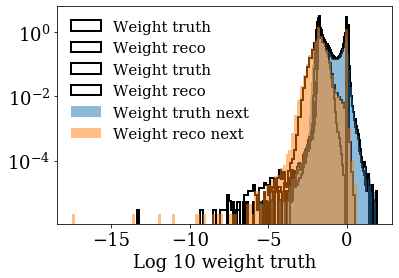

Iteration 0
79.36725616455078 1.2203396181575954e-05
1.0 2.2218364037485117e-08
 
Iteration 1
68.04943084716797 4.795372205990134e-06
3.301784038543701 4.5378157069626834e-14
 
Iteration 2
69.9074935913086 3.012810566360713e-06
4.171170234680176 3.434252071250708e-18
 


In [44]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_previous']),bins=100,**plot_style_1,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco_previous']),bins=100,**plot_style_1, label='Weight reco')

plt.hist(np.log10(mc_cut['weight_truth_next']),bins=100,**plot_style_2,label='Weight truth next')
plt.hist(np.log10(mc_cut['weight_reco_next']),bins=100,**plot_style_2, label='Weight reco next')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print ('Iteration %i'%i)
    print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    print(' ')

In [45]:
print(len(mc_cut))

mc_cut = mc_cut.query('weight_reco<100000 and weight_reco>0.00001')
mc_cut = mc_cut.query('weight_truth<100000 and weight_truth>0.00001')
print(len(mc_cut))

2500000
2499938


In [46]:
mc_cut = mc_cut.query('weight_reco_next<100000 and weight_reco_next>0.00001')
mc_cut = mc_cut.query('weight_truth_next<100000 and weight_truth_next>0.00001')

mc_cut = mc_cut.query('weight_reco_previous<100000 and weight_reco_previous>0.00001')
mc_cut = mc_cut.query('weight_truth_previous<100000 and weight_truth_previous>0.00001')

ITERATION: 1
ITERATION: 2
ITERATION: 3


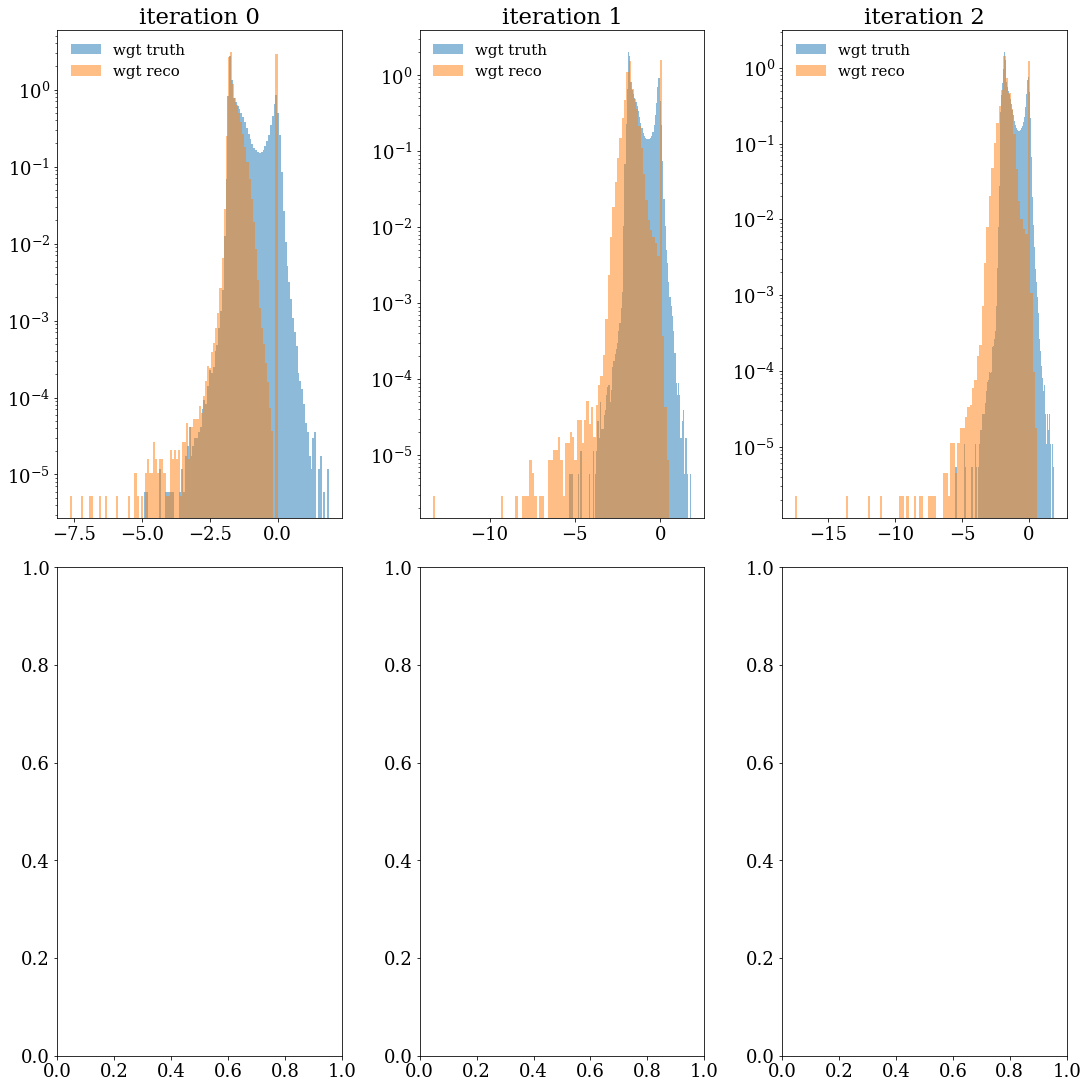

In [47]:
fig, ax = plt.subplots(2,
                           3,
                           figsize=(15, 15),
                           constrained_layout=True)
ax = ax.flatten()
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)
    
    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

In [49]:
mc_cut.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz', 'wgt', 'pass_reco', 'pass_truth',
       'jet_px', 'jet_py', 'jet_pz', 'jet_qt', 'jet_qtnorm', 'e_pt', 'e_phi',
       'logQ2', 'Q', 'gen_logQ2', 'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py',
       'genjet_pz', 'genjet_qt', 'genjet_qtnorm', 'gene_phi', 'genjet_dphi',
       'weight_reco', 'weight_truth', 'weight_reco_next', 'weight_truth_next',
       'weight_reco_previous', 'weight_truth_previous'],
      dtype='object')

## MC at reco level reweighted vs data

The query is: pass_reco==1 
ITERATION: 1


<ipython-input-50-27fbf6a639f5>:170: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


ITERATION: 2
ITERATION: 3


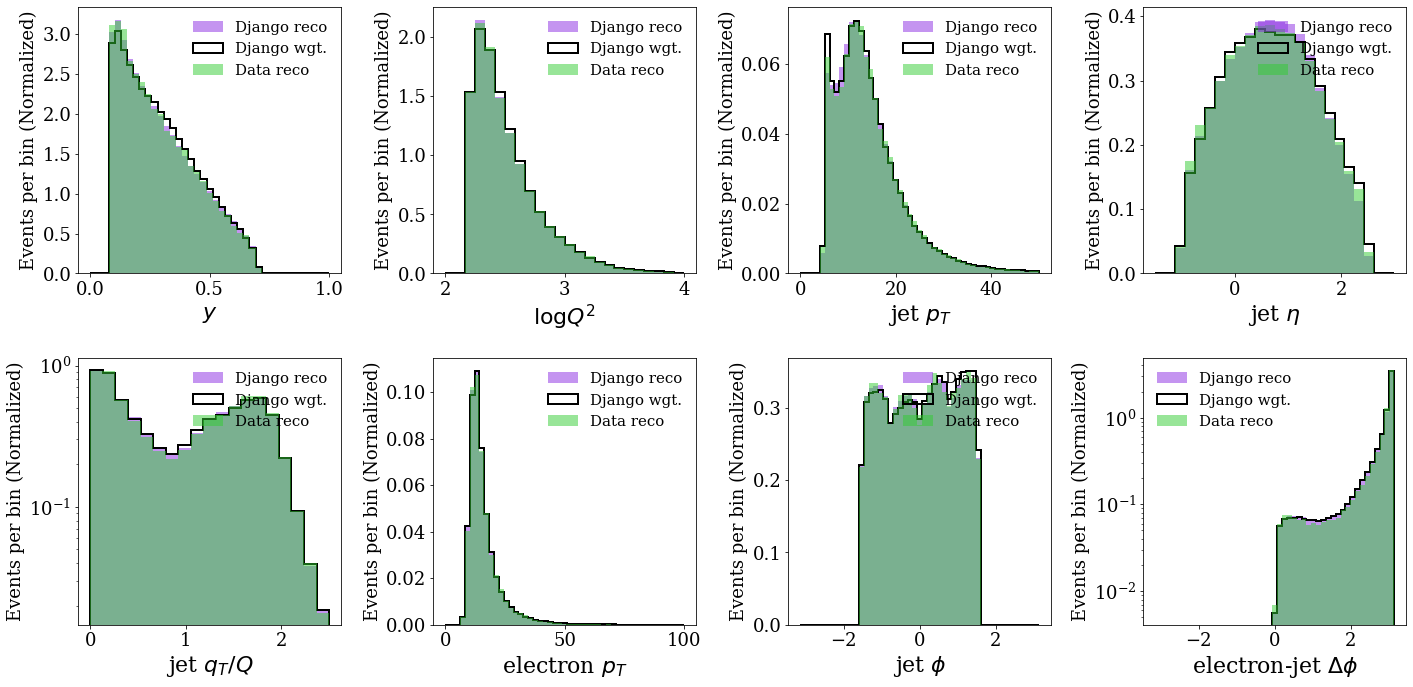

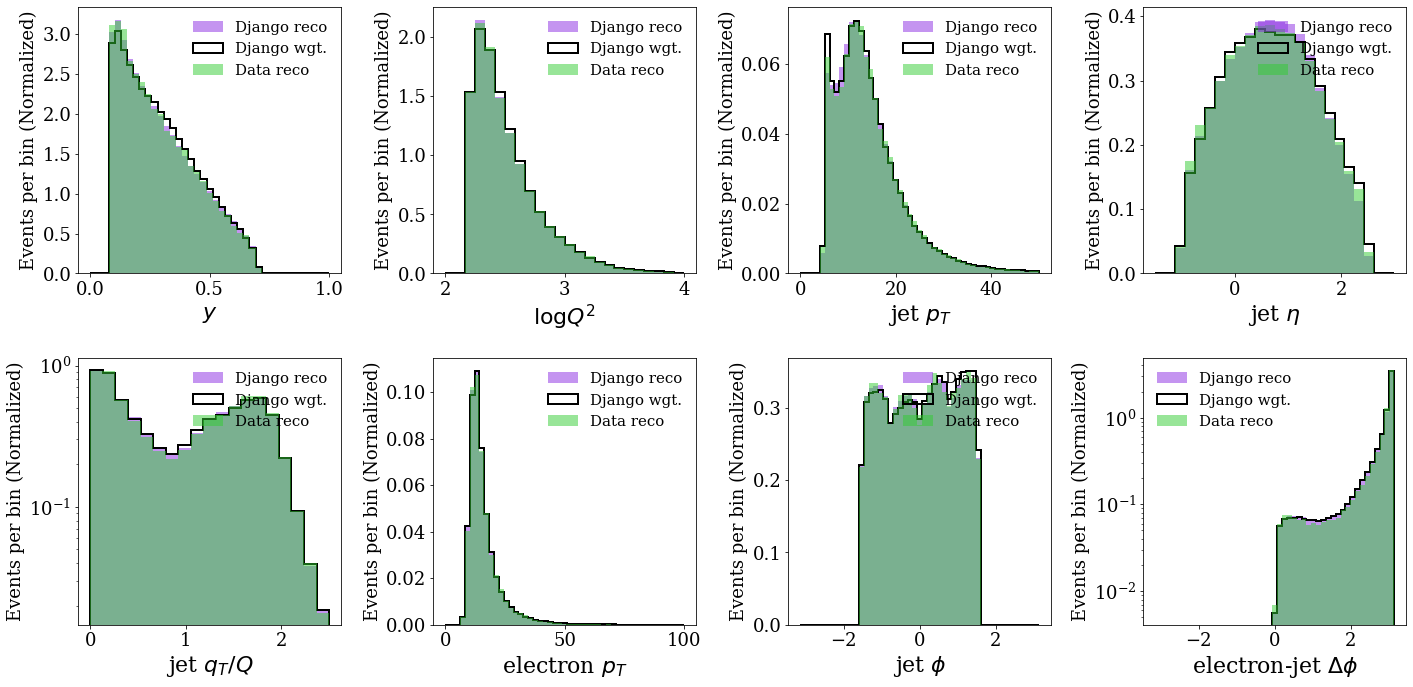

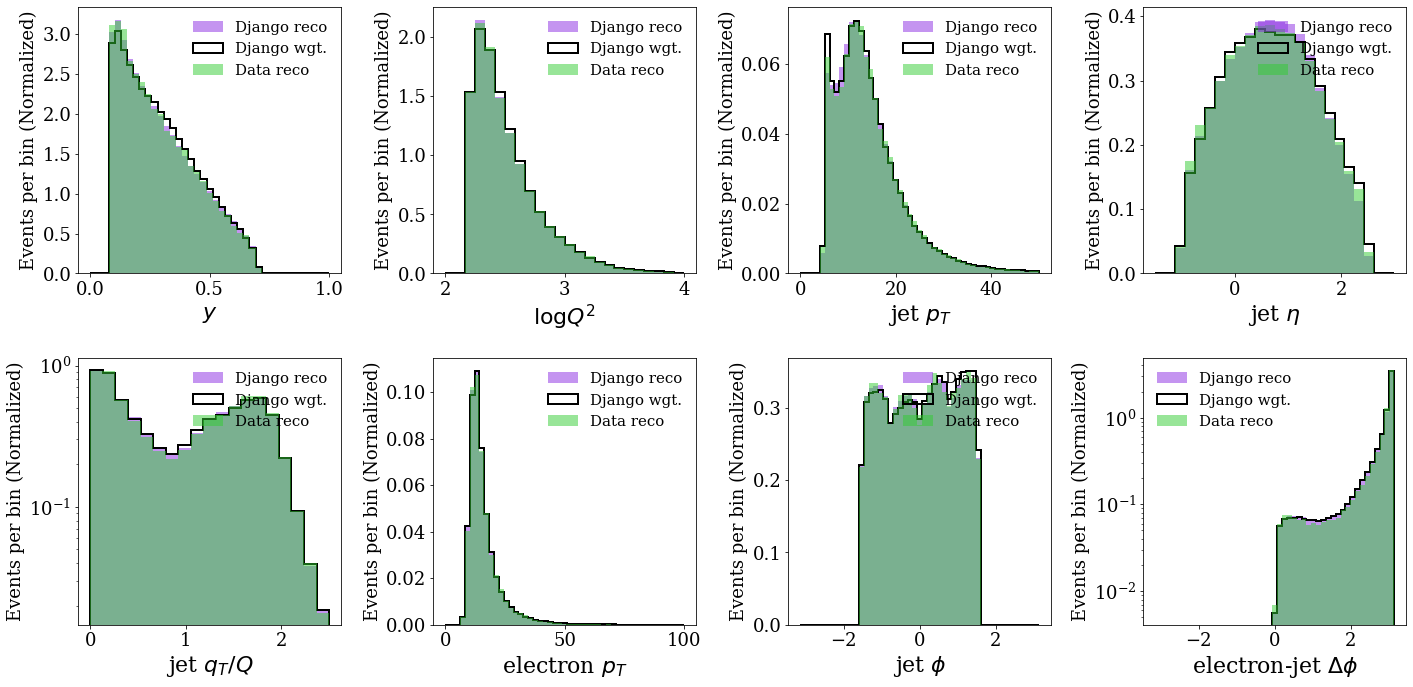

In [50]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = mc_name +' reco'
label2 = mc_name +' wgt.'
label3 = 'Data reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    
    ax = ax.flatten()

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['y'],bins=bins, weights= mc_cut.query(query)['wgt'],label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['logQ2'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel('jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['jet_pt'], weights= mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[3].set_xlabel('jet $\eta $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['jet_eta'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[4].set_xlabel('jet $q_{T}/Q $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[4].legend(frameon=False,loc='best')
    ax[4].set_yscale('log')

   
    bins = np.linspace(0,100,50)

    ax[5].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['e_pt'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[5].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(0,np.pi,50)

    ax[6].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['jet_phi'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[6].hist(mc_cut.query(query)['jet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[6].hist(data_cut.query(query)['jet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[6].legend(frameon=False,loc='best')
    

    bins = np.linspace(-np.pi,np.pi,50)

    ax[7].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['jet_dphi'],weights= mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[7].hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[7].hist(data_cut.query(query)['jet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[7].legend(frameon=False,loc='best')
    ax[7].set_yscale('log')
    
    plt.tight_layout()
    fig.savefig('figures/RealDataMC_comparison_inclusivejet_%i_iter_%s_%s_%s_data_%s.png'%(i,mc_name,mc_tag,period,data_tag)) 
    
    

## Plot unfolded results

In [ ]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
# ##track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):
    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    ax = ax.flatten()
    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['genjet_pt'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(0,2,20 )

    
    ax[3].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)


    bins = np.linspace(-1.5,3,25 )

    ax[4].set_xlabel(r'$jet eta $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['genjet_eta'], weights = mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    
    bins = np.linspace(0,100,25)

    ax[5].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['gene_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    

## Jet pT spectrum data reco vs MC reco

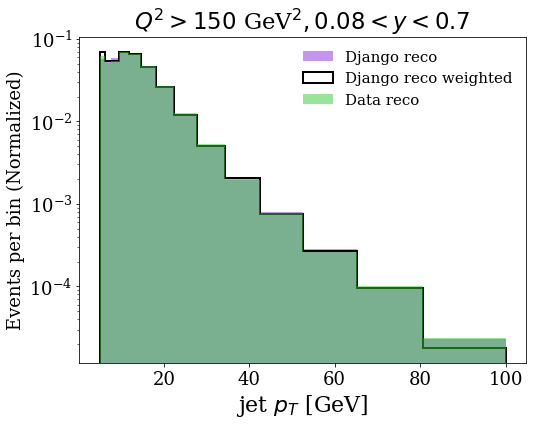

In [51]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),15)
#bins = np.array([5,10,14,21,29,47,71,127])

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], weights = mc_cut.query(query)['wgt'],bins=bins, 
         label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_jetpt_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


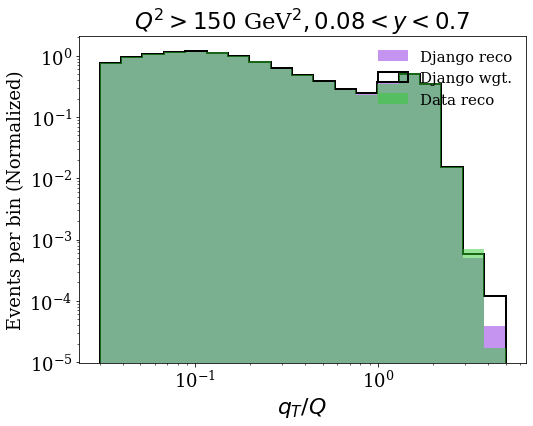

In [52]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(0.03),np.log10(5),20)

plt.hist(mc_cut.query(query)['jet_qtnorm'], weights = mc_cut.query(query)['wgt'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' wgt.',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'$q_{T}/Q $ ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
plt.xscale('log')
plt.legend(frameon=False,loc='best')


fig.savefig('figures/RealDataMC_jetqtnorm_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


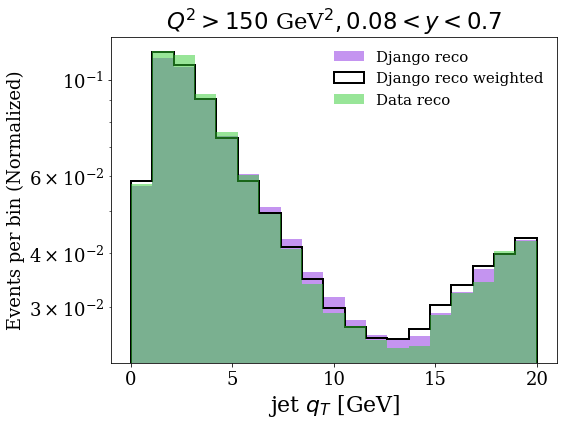

In [53]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
#bins = np.logspace(np.log10(5),np.log10(100),20)
#bins = np.array([5,10,14,21,29,47,71,127])
bins = np.linspace(0,20,20)
#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_qt'], bins=bins,  weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_qt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_qt'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $q_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_jetqt_inclusivejet_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


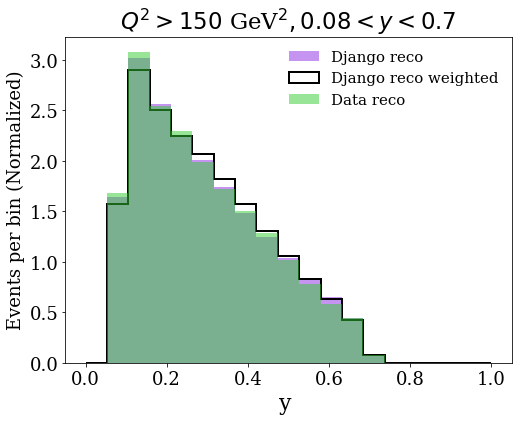

In [54]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.linspace(0,1,20)

plt.hist(mc_cut.query(query)['y'], bins=bins, weights = mc_cut.query(query)['wgt'], label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['y'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
#plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'y ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/DataMC_y_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [ ]:
print(len(mc_cut['y']))
print(len(mc_cut.query('pass_reco==1')['y']))

In [ ]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(0,1,40)

plt.hist(mc_cut.query('pass_reco==1')['y'], weights = mc_cut.query('pass_reco==1')['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
plt.hist(mc_cut.query('pass_reco==1')['gen_y'],weights = mc_cut.query('pass_reco==1')['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
plt.hist(mc_cut['gen_y'], bins=bins, weights = mc_cut['wgt'],label=mc_name+' truth', **plot_style_1A)


plt.legend()

In [ ]:
mc.keys()

In [ ]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(0,50,100)

plt.hist(mc_cut['jet_pt'], weights = mc_cut['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2A)
plt.hist(mc_cut.query('pass_reco==1')['genjet_pt'],  weights = mc_cut.query('pass_reco==1')['wgt'], bins=bins, label=mc_name+' truth, pass reco', **plot_style_2A)
plt.hist(mc_cut['genjet_pt'], weights = mc_cut['wgt'], bins=bins, label=mc_name+' truth', **plot_style_1A)


plt.legend()

## Data/MC agreement with differential 

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(-np.pi,np.pi,50)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,20), (20,30),(30,100)]):
    #cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'], weights=mc_cut.query(cut)['wgt'],bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_reco'],
               label=mc_name +' reco wgt.',
               **plot_style_1)
    axs[counter].hist(data_cut.query(cut)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)    
    
    
    axs[counter].legend(prop={'size': 15}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f < Q < %2.0f$ GeV'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/RealDataMCcomparison_dphi_diff_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 


In [ ]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),40)

plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label='Rapgap reco weighted', color='black', histtype='step', lw=2
               )

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               color=color2, alpha=0.5)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin ')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  



In [ ]:
altmc_cut = altmc

## Define fiducial region of the measurement

In [ ]:
fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'


## Plot data, and unfolded results and MC truth

In [ ]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.logspace(np.log10(10),np.log10(100),7)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_pt'],weights = mc_cut.query(cut)['wgt'], bins=bins,label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],weights = altmc_cut.query(cut)['wgt'],bins=bins,label = '%s truth'%(altmc_name),**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('jet $p_{T}$ [GeV]',fontsize=22)

plt.yscale('log')
plt.xscale('log')
fig.savefig('figures/Unfolded_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))

cut = fiducialregion
bins = np.linspace(-1,2.5,7)
plt.hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_eta'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)



#plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Rapgap truth',**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('jet $\eta_{lab}$ ',fontsize=22)


fig.savefig('figures/Unfolded_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.logspace(np.log10(0.03),np.log10(3),7)

plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('$q_{T}$/$Q$ ',fontsize=22)

plt.yscale('log')
plt.xscale('log')
fig.savefig('figures/Unfolded_jetqt_%s.png'%(mc_name)) 

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
cut = fiducialregion
bins = np.linspace(-np.pi/2.0,np.pi/2.0,20) 

plt.hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)

plt.hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights = mc_cut.query(cut)['wgt'],label = '%s truth'%(mc_name),**plot_style_2)

plt.hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,weights = altmc_cut.query(cut)['wgt'],label = '%s truth'%(altmc_name),**plot_style_2)

plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('$\Delta\phi$ ',fontsize=22)

plt.yscale('log')
#plt.xscale('log')
fig.savefig('figures/Unfolded_jetdphi_%s.png'%(mc_name)) 

plt.show()

## Final Cross section measurements. Save them in pickle files

In [ ]:
label_DISselection_truth = r'$Q^{2}>150$ GeV$^{2}, 0.2<y<0.7$'

In [ ]:
lumi = 139 #pb-1. This is for the 0607 dataset

## Calculate total jet cross-section


In [ ]:
fiducialregion = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and genjet_pt>10 and genjet_eta<2.5 and genjet_eta>-1.0'
bins = np.logspace(np.log10(10),np.log10(100),7)
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
total = np.sum(y)/lumi
print('Total cross-section is: %f' %total)

In [ ]:

fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(10),np.log10(100),7)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)

plt.yscale('log')
plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/CrossSection_jetpt_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_jetpt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)



In [ ]:
fig = plt.figure(figsize=(8,6))
bins = np.linspace(-1,2.5,6)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_eta'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)
plt.errorbar(x,y, xerr=xerr, fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $\eta$',fontsize=18)
plt.ylabel(r'd$\sigma/d\eta$ ',fontsize=18)
#plt.yscale('log')
#plt.xscale('log')

plt.title(label_DISselection_truth, fontsize=18)

fig.savefig('figures/CrossSection_jeteta_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_jeteta_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)


In [ ]:
fig = plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(0.03),np.log10(4),7)
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

print(y)
print(x)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
plt.ylabel(r'd$\sigma/dq_{T}/Q $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
plt.xscale('log')
fig.savefig('figures/CrossSection_jetqt_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_qt_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)

In [ ]:
fig = plt.figure(figsize=(8,6))

bins = np.linspace(-np.pi/2.0,np.pi/2.0,20) 
y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_dphi'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/lumi
y = y/total
y = y/(xerr*2.0)

plt.errorbar(x,y, xerr=xerr,fmt='o',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$\Delta\phi$ ',fontsize=18)
plt.ylabel(r'd$\sigma/d\Delta\phi  $ ',fontsize=18)
plt.yscale('log')
plt.title(label_DISselection_truth, fontsize=18)
fig.savefig('figures/CrossSection_jetdphi_%s.png'%(mc_name)) 

with open('outputfiles/CrossSection_dphi_%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag) , 'wb') as f:
    np.save(f, y)
    np.save(f, x)
    np.save(f, xerr)
#plt.xscale('log')

In [ ]:
print('%s_%s_%s_data_%s.npy'%(mc_name,mc_tag,period,data_tag))

# FIN

## Checking stability of the result vs number of iterations

In [ ]:
bins = np.logspace(np.log10(10),np.log10(100),7)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth'])
total = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total)


y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_next'])
total_next = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_next)

y,x = np.histogram(mc_cut.query(fiducialregion)['genjet_pt'],bins=bins,weights=mc_cut.query(fiducialregion)['weight_truth_previous'])
total_previous = np.sum(y)/lumi
print('Total cross-section is: %2.12f' %total_previous)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(10),np.log10(100),7)


cut = fiducialregion

ynom, x, _ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label='iterations=%i'%(iterations-1),histtype='step',lw=3)
ynext, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'],label='iterations=%i'%(iterations),alpha=0.5)
ydo, x, _ =ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'],label='iterations=%i'%(iterations-2),alpha=0.5)


xerr = (x[1:] - x[:-1])/2.0

ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous


ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr

x = (x[1:]+x[:-1])/2


ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
ratio = np.true_divide(ydo,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')
ax[1].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)
ax[0].set_xlabel(r'jet $p_{T}$ $[\mathrm{GeV}]$',fontsize=18)

#ax[0].set_ylim(bottom=1)
fig.savefig('figures/Iterations_jetpt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.linspace(-np.pi/2.0,np.pi/2.0,20) 

cut = fiducialregion

ynom, x, _ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label='iterations=%i'%(iterations-1),histtype='step',lw=3)
ynext, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'],label='iterations=%i'%(iterations),alpha=0.5)
ydo, x, _ =ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'],label='iterations=%i'%(iterations-2),alpha=0.5)


xerr = (x[1:] - x[:-1])/2.0

ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous


ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr

x = (x[1:]+x[:-1])/2


ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
ratio = np.true_divide(ydo,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dp_{T}$ ',fontsize=18)
ax[1].set_ylabel(' Ratio to nominal')



ax[1].set_xlabel(r'$\Delta\phi$ ',fontsize=18)
ax[0].set_xlabel(r'$\Delta\phi$ ',fontsize=18)

fig.savefig('figures/Iterations_jetdphi_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.logspace(np.log10(0.03),np.log10(4),7)

cut = fiducialregion

ynom, x, _ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label='iterations=%i'%(iterations-1),histtype='step',lw=3)
ynext, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'],label='iterations=%i'%(iterations),alpha=0.5)
ydo, x, _ =ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'],label='iterations=%i'%(iterations-2),alpha=0.5)


xerr = (x[1:] - x[:-1])/2.0

ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous


ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr

x = (x[1:]+x[:-1])/2


ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
ratio = np.true_divide(ydo,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()


ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dq_{T}/Q$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')
ax[0].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)
ax[1].set_xlabel(r'jet $q_{T}/Q$ ',fontsize=18)

ax[0].legend()
ax[0].set_xscale('log')

fig.savefig('figures/Iterations_jetqt_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))
bins = np.linspace(-1,2.5,8)
cut = fiducialregion
ynom, x, _ = ax[0].hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label='iterations=%i'%(iterations-1),histtype='step',lw=3)
ynext, x , _ = ax[0].hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_next'],label='iterations=%i'%(iterations),alpha=0.5)
ydo, x, _ =ax[0].hist(mc_cut.query(cut)['genjet_eta'],bins=bins,weights=mc_cut.query(cut)['weight_truth_previous'],label='iterations=%i'%(iterations-2),alpha=0.5)

xerr = (x[1:] - x[:-1])/2.0

ynom = ynom/total
ynext = ynext/total_next
ydo   = ydo/total_previous


ynom = ynom/xerr
ynext = ynext/xerr
ydo  = ydo/xerr

x = (x[1:]+x[:-1])/2

ax[0].legend()
ax[0].set_yscale('log')


ratio = np.true_divide(ynext,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations))
ratio = np.true_divide(ydo,ynom)
ax[1].plot(x,ratio,'o',label='iterations=%i'%(iterations-2))


ax[1].legend()

ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_ylabel(r'1/$\sigma_{jet}$ d$\sigma/dq_{T}/Q$ ',fontsize=18)

ax[1].set_ylabel(' Ratio to nominal')

ax[1].set_xlabel(r'jet $\eta$',fontsize=18)
ax[0].set_xlabel(r'jet $\eta$',fontsize=18)


fig.savefig('figures/Iterations_jeteta_%s_%s_%s_data_%s.png'%(mc_name,mc_tag,period,data_tag)) 

plt.show()

## Compare to ZEUS data

In [ ]:

fig = plt.figure(figsize=(8,6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.array([10,14,21,29,47,71,127])
y,x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/(xerr*2.0)
y = y/lumi


plt.errorbar(x,y, fmt='.',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$p_{T}$\ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'd$\sigma$/$p_{T}$ [normalized]',fontsize=18)



#heray = np.array([2685, 1408,599.9,165.55,40.59,7.90, 0.873, 0.0433])
#heraxdo = np.array([6,8,10,14,21,29,47,71])
#heraxup = np.array([8,10,14,21,29,47,71,127])


heray = np.array([599.9,165.55,40.59,7.90, 0.873, 0.0433])
heraxdo = np.array([10,14,21,29,47,71])
heraxup = np.array([14,21,29,47,71,127])
heraerrx = (heraxup-heraxdo)/2.0
herax = (heraxup+heraxdo)/2.0

ratio = np.true_divide(heray,y)


print(len(herax))
print(len(heray))
plt.errorbar(herax, 0.139*heray,xerr=heraerrx,label='HERA')
plt.legend(loc='best',frameon=False,fontsize=18)


plt.yscale('log')
plt.xscale('log')

print(ratio)

# FINISH data unfolding. Now starting CLOSURE TEST

## Define features using just MC and alt MC *this is CLOSURE TEST*

In [ ]:
mc_cut = mc[:2500000]
altmc_cut = altmc[:500000]

altmc_cut = altmc_cut.query('pass_reco==1')

print(len(mc_cut))
print(len(altmc_cut))

In [ ]:
print(len(mc_cut))
print(len(altmc_cut))

print(len(altmc_cut.query('pass_reco==1')))

In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_G = altmc_cut['gene_px']
epx_unknown_S = altmc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_G = altmc_cut['gene_py']
epy_unknown_S = altmc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_G = altmc_cut['gene_pz']
epz_unknown_S = altmc_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_G = altmc_cut['genjet_phi']
jetphi_unknown_S = altmc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']


jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_G = altmc_cut['genjet_dphi']
jetdphi_unknown_S = altmc_cut['jet_dphi']


#jetqt_0_G       = np.log10(mc_cut['genjet_qtnorm'])
#jetqt_0_S       = np.log10(mc_cut['jet_qtnorm'])
#jetqt_unknown_G = np.log10(altmc_cut['genjet_qtnorm'])
#jetqt_unknown_S = np.log10(altmc_cut['jet_qtnorm'])

jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_G = altmc_cut['genjet_qt']
jetqt_unknown_S = altmc_cut['jet_qt']

Q_0_G       = mc_cut['gen_Q']
Q_0_S       = mc_cut['Q']
Q_unknown_G = altmc_cut['gen_Q']
Q_unknown_S = altmc_cut['Q']


weights_MC_sim  = mc_cut['wgt']
weights_MC_data = altmc_cut['wgt']

In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G, Q_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S, Q_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G, jetdphi_unknown_G, jetqt_unknown_G, Q_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S, Q_unknown_S)]


In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

In [ ]:
bins = np.linspace(2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(-5,50, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold

In [ ]:
K.clear_session()

In [ ]:
help(multifold)

In [ ]:
%%time
iterations = 1# use ~4 iterations
num_observables= 9

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,
                       weights_MC_sim=weights_MC_sim,
                       weights_MC_data= weights_MC_data)

## Put weights into MC dataframe

In [ ]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check that weights are reasonable

In [ ]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Remove some large weights 

In [ ]:
%%time
print(len(mc_cut))
mc_cut.query('weight_truth>10000')
print(len(mc_cut.query(' weight_reco>0.00001')))

mc_cut = mc_cut.query('weight_reco<100000 and weight_reco>0.00001')
#altmc_cut = altmc_cut.query('weight_truth<10000')
print(len(mc_cut))

mc_cut = mc_cut.query('weight_truth<100000 and weight_truth>0.00001')
print(len(mc_cut))

## Closure Test

In [ ]:
%%time 
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
#track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection
print('The query is:' , query)

label1 = mc_name +' truth'
label2 = altmc_name + ' unfold.'
label3 = altmc_name + ' truth '


for i in range(len(weights)):
    #if(i<2): continue
    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    
    ax = ax.flatten()
    
    bins = np.linspace(0.0, 1.0,40 )

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], weights=mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0].hist(altmc_cut.query(query)['gen_y'],
               bins=bins,
               weights=altmc_cut.query(query)['wgt'],
               label=label3,
               **plot_style_2)
    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 5,50 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],weights=mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1].hist(altmc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=altmc_cut.query(query)['wgt'],
               label=label3,
               **plot_style_2)
    
    ax[1].legend(frameon=False)

    

    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel(r'jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['genjet_pt'],weights=mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[2].hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label=label3,
               weights=altmc_cut.query(query)['wgt'],
               **plot_style_2)
    
    ax[2].legend(frameon=False)


    bins = np.linspace(-1.5,3,25 )

    ax[3].set_xlabel(r'jet $\eta$',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['genjet_eta'],weights=mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[3].hist(altmc_cut.query(query)['genjet_eta'],
               bins=bins,
               label=label3,
               weights=altmc_cut.query(query)['wgt'],
               **plot_style_2)
    
    ax[3].legend(frameon=False)

    bins = np.linspace(0,100,50)

    ax[4].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['gene_pt'], weights=mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[4].hist(altmc_cut.query(query)['gene_pt'],
               bins=bins,
               label=label3,
               weights=altmc_cut.query(query)['wgt'],
               **plot_style_2)
    ax[4].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,2.5,20)

    ax[5].set_xlabel(r'jet $q_{T}/Q$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['genjet_qtnorm'], weights=mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[5].hist(altmc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               label=label3,
               weights=altmc_cut.query(query)['wgt'],
               **plot_style_2)
    ax[5].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(-np.pi,np.pi,50)

    ax[6].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['genjet_phi'],weights=mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[6].hist(mc_cut.query(query)['genjet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[6].hist(altmc_cut.query(query)['genjet_phi'],
               bins=bins,
               label=label3,
                weights=altmc_cut.query(query)['wgt'],
               **plot_style_2)
    ax[6].legend(frameon=False,loc='best')
    

    bins = np.linspace(-np.pi,np.pi,50)

    ax[7].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['genjet_dphi'],weights=mc_cut.query(query)['wgt'], bins=bins, label=label1, **plot_style_2)
    ax[7].hist(mc_cut.query(query)['genjet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[7].hist(altmc_cut.query(query)['genjet_dphi'],
               bins=bins,
               label=label3,
                weights=altmc_cut.query(query)['wgt'],

               **plot_style_2)
    ax[7].legend(frameon=False,loc='best')
    ax[7].set_yscale('log')

    fig.savefig('figures/Closure_inclusivejet_%i_iter_%s_%s.png'%(i,mc_name, altmc_name))

## Show the reweighting of the reco

In [ ]:
mc_cut.keys()
altmc_cut.keys()

In [ ]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = mc_name +' reco'
label2 = mc_name +' wgt.'
label3 = altmc_name +' reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    #if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    
    ax = ax.flatten()

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['y'], weights = mc_cut.query(query)['wgt'],bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(altmc_cut.query(query)['y'],
               bins=bins,
               label=label3,
               weights = altmc_cut.query(query)['wgt'],
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

#     bins = np.linspace(2, 4,25 )

#     ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
#     ax[1].set_ylabel('Events per bin (Normalized)')
#     ax[1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
#     ax[1].hist(mc_cut.query(query)['logQ2'],
#                bins=bins,
#                weights=mc_cut.query(query)['weight_reco'],
#                label=label2,
#                **plot_style_1)

#     ax[1].hist(altmc_cut.query(query)['logQ2'],
#                bins=bins,
#                label=label3,
#                **plot_style_2,color=color2)
    
#     ax[1].legend(frameon=False,loc='best')

    
#     bins = np.linspace(0,50,50 )

#     ax[2].set_xlabel('jet $p_{T}$',fontsize=22)
#     ax[2].set_ylabel('Events per bin (Normalized)')
#     ax[2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
#     ax[2].hist(mc_cut.query(query)['jet_pt'],
#                bins=bins,
#                weights=mc_cut.query(query)['weight_reco'],
#                label=label2,
#                **plot_style_1)

#     ax[2].hist(altmc_cut.query(query)['jet_pt'],
#                bins=bins,
#                label=label3,
#                **plot_style_2,color=color2)
#     #ax[0,2].set_yscale('log')
#     #ax[0,2].set_xscale('log')
#     ax[2].legend(frameon=False,loc='best')

    
#     bins = np.linspace(-1.5,3,25 )

#     ax[3].set_xlabel('jet $\eta $',fontsize=22)
#     ax[3].set_ylabel('Events per bin (Normalized)')
#     ax[3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
#     ax[3].hist(mc_cut.query(query)['jet_eta'],
#                bins=bins,
#                weights=mc_cut.query(query)['weight_reco'],
#                label=label2,
#                **plot_style_1)

#     ax[3].hist(altmc_cut.query(query)['jet_eta'],
#                bins=bins,
#                label=label3,
#                **plot_style_2,color=color2)
#     ax[3].legend(frameon=False,loc='best')
    

#     bins = np.linspace(0,2.5,20)
    
#     ax[4].set_xlabel('jet $q_{T}/Q $',fontsize=22)
#     ax[4].set_ylabel('Events per bin (Normalized)')
#     ax[4].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
#     ax[4].hist(mc_cut.query(query)['jet_qtnorm'],
#                bins=bins,
#                weights=mc_cut.query(query)['weight_reco'],
#                label=label2,
#                **plot_style_1)

#     ax[4].hist(altmc_cut.query(query)['jet_qtnorm'],
#                bins=bins,
#                label=label3,
#                **plot_style_2,color=color2)
    
#     ax[4].legend(frameon=False,loc='best')
#     ax[4].set_yscale('log')

   
#     bins = np.linspace(0,100,50)

#     ax[5].set_xlabel(r'electron $p_{T}$',fontsize=22)
#     ax[5].set_ylabel('Events per bin (Normalized)')
#     ax[5].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
#     ax[5].hist(mc_cut.query(query)['e_pt'],
#                bins=bins,
#                weights=mc_cut.query(query)['weight_reco'],
#                label=label2,
#                **plot_style_1)

#     ax[5].hist(altmc_cut.query(query)['e_pt'],
#                bins=bins,
#                label=label3,
#                **plot_style_2, color=color2)
    
#     ax[5].legend(frameon=False,loc='best')
    
    
#     bins = np.linspace(-np.pi,np.pi,50)

#     ax[6].set_xlabel(r'jet $\phi$',fontsize=22)
#     ax[6].set_ylabel('Events per bin (Normalized)')
#     ax[6].hist(mc_cut.query(query)['jet_phi'], bins=bins, label=label1, **plot_style_2,color=color1)
#     ax[6].hist(mc_cut.query(query)['jet_phi'],
#                bins=bins,
#                weights=mc_cut.query(query)['weight_reco'],
#                label=label2,
#                **plot_style_1)

#     ax[6].hist(altmc_cut.query(query)['jet_phi'],
#                bins=bins,
#                label=label3,
#                **plot_style_2, color=color2)
#     ax[6].legend(frameon=False,loc='best')
    

#     bins = np.linspace(-np.pi,np.pi,50)

#     ax[7].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
#     ax[7].set_ylabel('Events per bin (Normalized)')
#     ax[7].hist(mc_cut.query(query)['jet_dphi'], bins=bins, label=label1, **plot_style_2,color=color1)
#     ax[7].hist(mc_cut.query(query)['jet_dphi'],
#                bins=bins,
#                weights=mc_cut.query(query)['weight_reco'],
#                label=label2,
#                **plot_style_1)

#     ax[7].hist(altmc_cut.query(query)['jet_dphi'],
#                bins=bins,
#                label=label3,
#                **plot_style_2,color=color2)
#     ax[7].legend(frameon=False,loc='best')
#     ax[7].set_yscale('log')
    
#     plt.tight_layout()
#     fig.savefig('figures/DataMC_comparison_inclusivejet_%i_iter_%s_%s.png'%(i,mc_name, altmc_name)) 
    
    

## Check re-weighting at reco level for differential plots

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(-np.pi,np.pi,100)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,25), (25,50),(50,100)]):
    #cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_reco'],
               label=mc_name +' reco wgt.',
               **plot_style_1)
    axs[counter].hist(altmc_cut.query(cut)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)    
    
    
    axs[counter].legend(prop={'size': 16}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f< Q < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/DataMCcomparison_dphi_diff_%s_%s.png'%(mc_name,altmc_name)) 


In [ ]:
bins = np.linspace(-np.pi/2.0,np.pi/2.0,40 )
#query = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
query  = 'pass_reco==1 and gen_Q>30'
#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_dphi'], bins=bins, label=label1, **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

plt.hist(altmc_cut.query(query)['jet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
plt.yscale('log')
plt.legend(frameon=False,loc='best')

## Closure Test  jet pT spectrum

In [ ]:
plt.hist(altmc_cut.query(cut)['genjet_qtnorm'],range=(0,0.1),bins=100,label='Rapgap Truth')
plt.yscale('log')


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
cut = cut + ' and pass_reco==1'
bins = np.logspace(np.log10(10),np.log10(100),8)
#bins = np.array([10,14,21,29,47,71,127])

ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label= mc_name+' Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label=altmc_name+' Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = altmc_name+' unfolded',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_xlabel('$p_{T}^{jet}$ [GeV]')
ax[1].set_xlabel('$p_{T}^{jet}$ [GeV]')

ax[0].set_ylabel('Events per bin (Normalized)')
ax[1].set_ylabel('Unfolded/Truth')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.90,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

#lt.tight_layout()
fig.savefig('figures/Closure_jetpt_%s_%s.png'%(mc_name, altmc_name))  

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
cut = cut + ' and pass_reco==1'

#bins = np.linspace(0,3,6)
bins = np.logspace(np.log10(0.03),np.log10(3),8)
ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label=mc_name + ' Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label=altmc_name+ ' Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = altmc_name+' unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.9,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

ax[0].set_xlabel('jet $q_{T}/Q$')
ax[1].set_xlabel('jet $q_{T}/Q$')

ax[0].set_ylabel('Events per bin (Normalized)')
ax[1].set_ylabel('Unfolded/Truth')

#plt.tight_layout()
fig.savefig('figures/Closure_jetqt_%s_%s.png'%(mc_name, altmc_name))  


plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'# and genjet_pt<20 '
cut = cut + ' and pass_reco==1'
bins = np.linspace(-np.pi/2.0,np.pi/2.0,20) 
ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,label=mc_name+' Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,label=altmc_name+ ' Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = altmc_name+' unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_xlabel('electron-jet $\Delta\phi$ [rad]')
ax[1].set_xlabel('electron-jet $\Delta\phi$ [rad]')

ax[0].set_ylabel('Events per bin (Normalized)')
ax[1].set_ylabel('Unfolded/Truth')

ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
fig.savefig('figures/Closure_dphi_%s_%s.png'%(mc_name, altmc_name))  

plt.show()

## Closure for dphi but differentially in Q

In [ ]:
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'# and genjet_pt<20 '
cut = cut + ' and pass_reco==1'
bins = np.linspace(-np.pi/2.0,np.pi/2.0,40) 

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,20), (20,30),(30,100)]):
    cut = ' gen_Q > %2.2f and gen_Q<%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
    cut = cut + ' and genjet_pt>10'# and genjet_pt<20 '
    cut = cut + ' and pass_reco==1'#cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    #cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['genjet_dphi'], bins=bins, label=mc_name+' reco', **plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_truth'],
               label= altmc_name + ' unfold.',
               **plot_style_1)
    axs[counter].hist(altmc_cut.query(cut)['genjet_dphi'],
               bins=bins,
               label=altmc_name + ' truth',
               **plot_style_2)    
    
    
    axs[counter].legend(prop={'size': 16}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f< Q < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/Closure_dphi_diff_%s_%s.png'%(mc_name,altmc_name)) 

## check weights

In [ ]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Compute some efficiency

In [ ]:
fig= plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(5),np.log10(100),20)
num,x,_  = plt.hist(mc_cut.query('pass_reco==1')['genjet_pt'], weights=mc_cut.query('pass_reco==1')['weight_truth'],bins=bins,label='numerator, weighted',alpha=0.5)
den,x,_  = plt.hist(mc_cut['genjet_pt'], weights=mc_cut['weight_truth'],bins=bins,label='denominator, weighted',alpha=0.5)
x= (x[1:] + x[:-1])/2.0

plt.xlabel('jet $p_{T}$ [GeV]')
plt.legend()
plt.show()
eff_weighted= np.true_divide(num,den)

plt.tight_layout()

fig.savefig('figures/efficiency_part1.png')  


In [ ]:


fig= plt.figure(figsize=(8,6))

plt.xlabel('jet $p_{T}$ [GeV]')
plt.ylabel('Efficiency')

plt.plot(x,eff_weighted,'o')
plt.xscale('log')
#plt.tight_layout()
plt.tight_layout()

fig.savefig('figures/efficiency_part2.png')  


In [ ]:
K.clear_session()

## Bootstrapping

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']

jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']


Q_0_G           = mc_cut['gen_Q']
Q_0_S           = mc_cut['Q']


In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G, Q_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S,Q_0_S)]
 

In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 50
iterations =  4
nvariables = 8
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    K.clear_session()
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    epx_unknown_S       = bootstrap_data['e_px']
    epy_unknown_S       = bootstrap_data['e_py']
    epz_unknown_S       = bootstrap_data['e_pz'] 
    jetpt_unknown_S     = bootstrap_data['jet_pt']
    jeteta_unknown_S    = bootstrap_data['jet_eta']
    jetphi_unknown_S    = bootstrap_data['jet_phi']
    jetdphi_unknown_S   = bootstrap_data['jet_dphi']
    jetqt_unknown_S     = bootstrap_data['jet_qt']
    Q_unknown_S         = bootstrap_data['Q']
    theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, 
                            jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S, Q_unknown_S)]

    
    
    num_observables = 9
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,
                       verbose =0
                      )
    
    
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
print(len(weights))

## for k in range(bootstraps):
    for i in range(len(weights[k])):
        print (weights[k].shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1:2, :][0]).shape)


In [ ]:
covariance_matrices = []
for it in range(3):
    myns = []
    #bins = np.logspace(np.log10(0.01),np.log10(80),6)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(np.log10(0.03),np.log10(3),5)
    #bins = np.logspace(np.log10(10),np.log10(100),5)
    cut = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and pass_reco==1 and genjet_pt>10.0'
    for k in range(len(weights)):
        mc_cut['weight_temp'] =weights[k][it, 1, :]

        n,b,_ = plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_temp'],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    #plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0

ax = ax.flatten()

im = ax[0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
#im = ax[3].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
#                  interpolation='none')
#im = ax[4].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
#                  interpolation='none')
#im = ax[6].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
#                  interpolation='none')


ax[0].set_title('iteration #0')
ax[1].set_title('iteration #1')
ax[2].set_title('iteration #2')
ax[3].set_title('iteration #3')
ax[4].set_title('iteration #4')
ax[5].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(4): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it+1)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
np.logspace(np.log10(0.01),np.log10(3),6)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()